In [1]:
!gdown --id 1uSOMmTyb4DM9GKZ44PV5HK3qT5_szB9n
!gdown --id 190g_R6_Aa2tD6sirNd4yWNTVtgrEJFht
!gdown --id 1BBY0N1MzlvRWtaJCe_aodiimzpsKgEsO

Downloading...
From: https://drive.google.com/uc?id=1uSOMmTyb4DM9GKZ44PV5HK3qT5_szB9n
To: /content/square.jpg
100% 2.10k/2.10k [00:00<00:00, 753kB/s]
Downloading...
From: https://drive.google.com/uc?id=190g_R6_Aa2tD6sirNd4yWNTVtgrEJFht
To: /content/bongban.jpg
100% 26.5k/26.5k [00:00<00:00, 28.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BBY0N1MzlvRWtaJCe_aodiimzpsKgEsO
To: /content/circle.jpg
100% 28.0k/28.0k [00:00<00:00, 38.3MB/s]


In [2]:
import time
from functools import wraps

def calc_time(f):
  @wraps(f)
  def wrapper(*args, **kwds):
    start = time.time()
    result = f(*args, **kwds)
    elapsed = time.time() - start
    print("%s took %s" % (f.__name__, elapsed))
    return result
  return wrapper

# **Hough Line Transform**

In [3]:
import numpy as np


class HoughLineDetection:
    def __init__(self, rho=1, theta=np.pi/180, threshold=120):
        self.rho = rho
        self.theta = theta
        self.threshold = threshold
    
    @calc_time
    def detect_line(self, image, angle_step=1):
        """
        Hough transform for lines
        Input:
        image - 2D binary image with nonzeros representing edges
        angle_step - Spacing between angles to use every n-th angle
                    between -90 and 90 degrees. Default step is 1.
        Returns:
        accumulator - 2D array of the hough transform accumulator
        theta - array of angles used in computation, in radians.
        rhos - array of rho values. Max size is 2 times the diagonal
            distance of the input image.
        """
        # Rho and Theta ranges
        thetas = np.deg2rad(np.arange(0., 180.0, angle_step))
        width, height = image.shape
        diagonal = int(round((width * width + height * height) ** 0.5))
        rhos = np.linspace(- diagonal, diagonal, diagonal * 2)
        num_rhos = diagonal // self.rho

        # Cache some resuable values
        cos_thetas = np.cos(thetas)
        sin_thetas = np.sin(thetas)
        num_thetas = len(thetas)

        # Hough accumulator array of theta vs rho
        edge_matrix = np.zeros((2 * diagonal, num_thetas), dtype=np.uint8)
        # (row, col) indexes to edges
        y_idxs, x_idxs = np.nonzero(image)

        # Vote in the hough accumulator
        for i in range(len(x_idxs)):
            x = x_idxs[i]
            y = y_idxs[i]

            for t_idx in range(num_thetas):
                # Calculate rho. diag_len is added for a positive index
                rho = diagonal + int(round(x * cos_thetas[t_idx] + y * sin_thetas[t_idx]))
                edge_matrix[rho, t_idx] += 1
        
        rho_values, theta_values = np.where(edge_matrix > self.threshold)    
        rho_values = [r - num_rhos for r in rho_values]
        theta_values = [t / 180.0 * np.pi for t in theta_values]
        line_indices = [(r, theta) for r, theta in zip(rho_values, theta_values)]   

        return line_indices, edge_matrix, thetas, rhos

In [4]:
import matplotlib.pyplot as plt
import cv2

image = cv2.imread('square.jpg', 0)
image_detected = image.copy()
opencv_out = image.copy()

edges = cv2.Canny(image, 50, 150)

hough = HoughLineDetection()
line_indices = hough.detect_line(edges)[0]

for line in line_indices:
    rho, theta = line
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(image_detected, (x1,y1), (x2,y2), (0,0,255), 2)

detect_line took 3.9898266792297363


In [5]:
# OpenCV
import time

t1 = time.time()
lines = cv2.HoughLines(edges, rho=1, theta=np.pi/180, threshold=100)
t2 = time.time()

print(f'openCV took {t2 - t1}s')

for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(opencv_out, (x1,y1), (x2,y2), (0,0,255), 2)

openCV took 0.003339052200317383s


[]

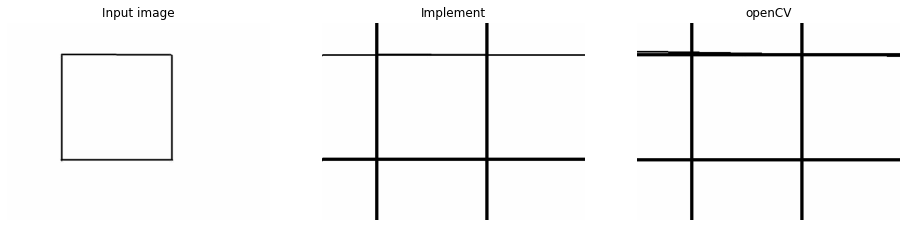

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(16, 10))

ax[0].imshow(image, cmap="gray")
ax[0].set_title('Input image')
ax[0].axis('off')

ax[1].imshow(image_detected, cmap="gray")
ax[1].set_title('Implement')
ax[1].axis('off')

ax[2].imshow(opencv_out, cmap="gray")
ax[2].set_title('openCV')
ax[2].axis('off')

plt.plot()

# Detection of Circle

In [8]:
class HoughCircleDetection:
    def __init__(self, rmin=10, rmax=20, step=180, threshold=0.4):
        self.rmin = rmin
        self.rmax = rmax
        self.step = step
        self.threshold = threshold
        
    def detect(self, image):
        points = []
        angle = 2 * np.pi / self.step
        for r in range(self.rmin, self.rmax + 1):
            for t in range(self.step):
                points.append((r, int(r * np.cos(angle * t)), int(r * np.sin(angle * t))))
        
        acc = defaultdict(int)
        edges = np.squeeze(cv2.findNonZero(image))
        for x, y in edges:
            for r, dx, dy in points:
                a = x - dx
                b = y - dy
                acc[(a, b, r)] += 1
            
        circles = []
        for k, v in sorted(acc.items(), key=lambda i: -i[1]):
            x, y, r = k
            if v / self.step >= self.threshold and all((x - xc) ** 2 + (y - yc) ** 2 > rc ** 2 for xc, yc, rc in circles):
                circles.append((x, y, r))
        
        return circles
    
    @calc_time
    def detect_circles(self, image):
        angles = np.arange(0, 2 * math.pi, 2 * math.pi / self.step)
        radius = np.arange(self.rmin, self.rmax, 1)

        radius_arr = np.broadcast_to(np.expand_dims(radius, axis=1), (radius.size, angles.size))
        angles_arr = np.broadcast_to(np.expand_dims(angles, axis=0), (radius.size, angles.size))
        dx = radius_arr * np.cos(angles_arr)
        dy = radius_arr * np.sin(angles_arr) 
        dxy = np.stack((dx, dy), axis=2) 
        

        edges = np.squeeze(cv2.findNonZero(image)) 
        
        dxy_arr = np.broadcast_to(np.expand_dims(dxy, axis=0), shape=(edges.shape[0], dxy.shape[0], dxy.shape[1], dxy.shape[2]))
        edges = np.broadcast_to(np.expand_dims(edges, axis=(1, 2)), shape=(edges.shape[0], dxy.shape[0], dxy.shape[1], edges.shape[1]))
            
        circles = edges - dxy_arr 

(-0.5, 279.5, 279.5, -0.5)

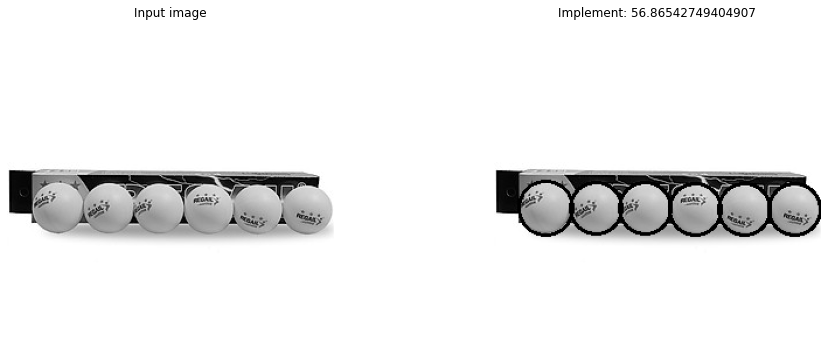

In [9]:
from collections import defaultdict
import time

image = cv2.imread('bongban.jpg', 0)
image_detected = image.copy()

start_time = time.time()
edge = cv2.Canny(image, 50, 150)
hough = HoughCircleDetection(15, 30, 180, 0.5)

circles = hough.detect(edge)

for x, y, r in circles:
    cv2.circle(image_detected, (x, y), r, (0, 255, 0), 2)
my_time = time.time() - start_time


fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Input image')
ax[0].axis('off')

ax[1].imshow(image_detected, cmap="gray")
ax[1].set_title('Implement: ' + str(my_time))
ax[1].axis('off')

Hough Circle Detection using openCV

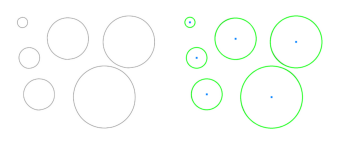

In [10]:
image = cv2.imread('circle.jpg')
image_detected = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1.2, 100)
if circles is not None:
	circles = np.round(circles[0, :]).astype("int")
	for (x, y, r) in circles:
		cv2.circle(image_detected, (x, y), r, (0, 255, 0), 4)
		cv2.rectangle(image_detected, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)

plt.axis('off')
plt.imshow(np.hstack([image, image_detected]))